# Using Physics-Based Loss to Better Generalize Model Training 
From modified Beer-Lambert Law, we know that 
$$
\Delta OD = <L_i(r)> \Delta \mu_(a,i)
$$
Where, $\Delta OD$ is the pulsation ratio(for a given wavelength) defined as $log(I_2)/log(I_1)$, i is the index of the tissue layer where pulsation occurs, $<L>$ corresponds to the source-detector distance (SDD) dependent **mean** photon pathlength within that layer. This can be further modified as 
$$
\Delta OD = <L_i(r)> \Delta c_(Hb) \times \epsilon(S)
$$
The corresponding loss term should thus be
$$
(\Delta OD - <L_i(r)> \Delta c_(Hb) \times \epsilon(S)) ^ 2
$$


In [39]:
from pathlib import Path
import json
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.model_training import (
    ModelTrainer,
    RandomSplit,
    CVSplit,
    SumLoss,
    TorchLossWrapper,
    BLPathlengthLoss,
    BLPathlengthLossDelta,
    DataLoaderGenerator3,
    TorchLossWithChangingWeight
)
from inverse_modelling_tfo.model_training.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN,
)
from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Pre-save data

In [41]:
file_name1 = 'I1_and_I2'
file_name2 = 'pulsation_ratio'

# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.pkl"
data1 = pd.read_pickle(DATA_PATH)
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.pkl"
data2 = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.json"
with open(CONFIG_PATH, "r") as f:
    config1 = json.load(f)
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.json"
with open(CONFIG_PATH, "r") as f:
    config2 = json.load(f)
labels = config1["labels"]  # Should have the same labels
intensity = config1["features"]
pulsation_ratio = config2["features"]

data = pd.merge(data1, data2, on=labels, how="inner")

# Cleanup
data.dropna(inplace=True)

In [42]:
# Filter data so I don't have to wait for too long during training
data = data[
    (data["Maternal Wall Thickness"] >= 4.0)
    & (data["Maternal Wall Thickness"] <= 16.0)

    & (data["Fetal Saturation"] > 0.2)
    & (data["Maternal Saturation"] > 0.96)
]
print("training with", len(data), "samples")

training with 136080 samples


In [43]:
data.columns

Index(['10_2.0_1', '15_2.0_1', '19_2.0_1', '24_2.0_1', '28_2.0_1', '33_2.0_1',
       '37_2.0_1', '41_2.0_1', '46_2.0_1', '50_2.0_1',
       ...
       'MAX_ACbyDC_WV1_15', 'MAX_ACbyDC_WV2_15', 'MAX_ACbyDC_WV1_16',
       'MAX_ACbyDC_WV2_16', 'MAX_ACbyDC_WV1_17', 'MAX_ACbyDC_WV2_17',
       'MAX_ACbyDC_WV1_18', 'MAX_ACbyDC_WV2_18', 'MAX_ACbyDC_WV1_19',
       'MAX_ACbyDC_WV2_19'],
      dtype='object', length=127)

# Combining Physics Based Terms

In [44]:
# Create the pathlength mean columns
pathlength_stats = Path(r'/home/rraiyan/simulations/tfo_sim/data/pathlength_stats/dan_iccps_pencil2.pkl')
pathlength_stats = pd.read_pickle(pathlength_stats)

l4_mean_column_names = list(filter(lambda x: 'L4 ppath_mean' in x, pathlength_stats.columns))
wv1_ppath = (pathlength_stats[pathlength_stats['Wave Int'] == 1])[['Maternal Wall Thickness'] + l4_mean_column_names]
wv2_ppath = (pathlength_stats[pathlength_stats['Wave Int'] == 2])[['Maternal Wall Thickness'] + l4_mean_column_names]
wv1_ppath.set_index(['Maternal Wall Thickness'], inplace=True)
wv2_ppath.set_index(['Maternal Wall Thickness'], inplace=True)
pathlength_stats.drop(columns=['Wave Int'], inplace=True)   # Don't need this column anymore

# Append the pathlength stats to the data
for column in wv1_ppath.columns:
    data[column + ' WV1'] = data['Maternal Wall Thickness'].map(wv1_ppath[column])
for column in wv2_ppath.columns:
    data[column + ' WV2'] = data['Maternal Wall Thickness'].map(wv2_ppath[column])

# Defining feature groups
wv1_pulsation_ratio = list(filter(lambda x: 'WV1' in x, pulsation_ratio))
wv2_pulsation_ratio = list(filter(lambda x: 'WV2' in x, pulsation_ratio))
wv1_intensity = list(filter(lambda x: '1.0' in x, intensity))
wv2_intensity = list(filter(lambda x: '2.0' in x, intensity))
wv1_ppath = [x + ' WV1' for x in l4_mean_column_names]  # Replace with the new column names
wv2_ppath = [x + ' WV2' for x in l4_mean_column_names]  # Replace with the new column names

# Pulsation Ratio copy (This will be left unscaled)
unscaled_pulsation_ratio_columns = [x + ' unscaled' for x in pulsation_ratio]
temp = data[pulsation_ratio]
temp.columns = unscaled_pulsation_ratio_columns
data = pd.concat([data, temp], axis=1)  # Avoids contiguity issues

# Calculate The BL-Based Term 

In [45]:
from inverse_modelling_tfo.tools.optical_properties import get_tissue_mu_a

def calculate_mua0_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 0"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua1_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua0_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 0"], row["Fetal Saturation"], wave_int=1)
    return mu_a

def calculate_mua1_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=1)
    return mu_a

data["Fetal Mua 0 WV2"] = data.apply(calculate_mua0_wv2, axis=1)
data["Fetal Mua 1 WV2"] = data.apply(calculate_mua1_wv2, axis=1)
data["Fetal Mua 0 WV1"] = data.apply(calculate_mua0_wv1, axis=1)
data["Fetal Mua 1 WV1"] = data.apply(calculate_mua1_wv1, axis=1)

data["Delta Mu WV2"] = data["Fetal Mua 1 WV2"] - data["Fetal Mua 0 WV2"]
data["Delta Mu WV1"] = data["Fetal Mua 1 WV1"] - data["Fetal Mua 0 WV1"]

# Generate the BL columns
# Create an empty dataframe, fillup with BLs, concat back into original, this way avoids data contiguity issues
bl_column_names = [f'{column}_BL WV1' for column in l4_mean_column_names] + [f'{column}_BL WV2' for column in l4_mean_column_names]
unscaled_bl_df = pd.DataFrame(columns=bl_column_names)
for wv1_column, wv2_column, column in zip(wv1_ppath, wv2_ppath, l4_mean_column_names):
    unscaled_bl_df[f'{column}_BL WV1'] = data[wv1_column] * (data['Fetal Mua 0 WV1'] - data['Fetal Mua 1 WV1'])
    unscaled_bl_df[f'{column}_BL WV2'] = data[wv2_column] * (data['Fetal Mua 0 WV2'] - data['Fetal Mua 1 WV2'])
data = pd.concat([data, unscaled_bl_df], axis=1)
# Get the indices
bl_column_indices = [data.columns.get_loc(column) for column in bl_column_names]

# Setup Training Objective

In [46]:
# Predict the mu_a as well as the pathlengths for each detector
y_columns = ['Fetal Mua 0 WV1', 'Fetal Mua 1 WV1', 'Fetal Mua 0 WV2', 'Fetal Mua 1 WV2'] + wv1_ppath + wv2_ppath  # MuA + Partial pathlengths
# y_columns = ["Delta Mu WV1", "Delta Mu WV2"] + wv1_ppath + wv2_ppath  # delta MuA + Partial pathlengths

# x_columns = features  # What to use as input
# x_columns = intensity  # What to use as input
x_columns = pulsation_ratio

## Normalizing Features
x_columns will be the input features and y_columns are the target

In [47]:
## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))
## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
## Scheme 1 - Per detector normalization
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Model Configuration

In [48]:
print("In Features :", x_columns)  
print("In Features Len:", len(x_columns))
print("Out Features:", y_columns)
print("Out Features Len:", len(y_columns))
print("Extra Features:", unscaled_pulsation_ratio_columns)
print("Extra Features Len:", len(unscaled_pulsation_ratio_columns))

In Features : ['MAX_ACbyDC_WV1_0', 'MAX_ACbyDC_WV1_1', 'MAX_ACbyDC_WV1_2', 'MAX_ACbyDC_WV1_3', 'MAX_ACbyDC_WV1_4', 'MAX_ACbyDC_WV1_5', 'MAX_ACbyDC_WV1_6', 'MAX_ACbyDC_WV1_7', 'MAX_ACbyDC_WV1_8', 'MAX_ACbyDC_WV1_9', 'MAX_ACbyDC_WV1_10', 'MAX_ACbyDC_WV1_11', 'MAX_ACbyDC_WV1_12', 'MAX_ACbyDC_WV1_13', 'MAX_ACbyDC_WV1_14', 'MAX_ACbyDC_WV1_15', 'MAX_ACbyDC_WV1_16', 'MAX_ACbyDC_WV1_17', 'MAX_ACbyDC_WV1_18', 'MAX_ACbyDC_WV1_19', 'MAX_ACbyDC_WV2_0', 'MAX_ACbyDC_WV2_1', 'MAX_ACbyDC_WV2_2', 'MAX_ACbyDC_WV2_3', 'MAX_ACbyDC_WV2_4', 'MAX_ACbyDC_WV2_5', 'MAX_ACbyDC_WV2_6', 'MAX_ACbyDC_WV2_7', 'MAX_ACbyDC_WV2_8', 'MAX_ACbyDC_WV2_9', 'MAX_ACbyDC_WV2_10', 'MAX_ACbyDC_WV2_11', 'MAX_ACbyDC_WV2_12', 'MAX_ACbyDC_WV2_13', 'MAX_ACbyDC_WV2_14', 'MAX_ACbyDC_WV2_15', 'MAX_ACbyDC_WV2_16', 'MAX_ACbyDC_WV2_17', 'MAX_ACbyDC_WV2_18', 'MAX_ACbyDC_WV2_19']
In Features Len: 40
Out Features: ['Fetal Mua 0 WV1', 'Fetal Mua 1 WV1', 'Fetal Mua 0 WV2', 'Fetal Mua 1 WV2', 'L4 ppath_mean_10 WV1', 'L4 ppath_mean_15 WV1', 'L4 pp

# Training Configs

In [49]:
from inverse_modelling_tfo.model_training.validation_methods import HoldOneOut

IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)
set_seed(42)
data_loader_params = {"shuffle": True}  # Shuffles the data in between epochs - thought to be a good idea
dataloader_gen = DataLoaderGenerator3(data, x_columns, y_columns, unscaled_pulsation_ratio_columns, 512, data_loader_params)

# criterion = nn.MSELoss()
criterion1 = TorchLossWrapper(nn.MSELoss(), name="label_loss")
criterion2 = BLPathlengthLoss(0, 1, list(range(4, 24)), list(range(20)), y_scaler, name="physics_loss_wv1")
# criterion2 = BLPathlengthLossDelta(0, list(range(2, 22)), list(range(20)), y_scaler, name="physics_loss_wv1")
# criterion2 = TorchLossWithChangingWeight(criterion2, 1.0, 20.0, 20, 15, name="physics_loss_wv1")
criterion3 = BLPathlengthLoss(2, 3, list(range(24, 44)), list(range(20, 40)), y_scaler, name="physics_loss_wv2")
# criterion3 = BLPathlengthLossDelta(1, list(range(22, 42)), list(range(20, 40)), y_scaler, name="physics_loss_wv2")
# criterion3 = TorchLossWithChangingWeight(criterion3, 1.0, 20.0, 20, 15, name="physics_loss_wv2")
# criterion = SumLoss([criterion1, criterion2, criterion3], [1.0, 0.5, 0.5])
criterion = SumLoss([criterion1, criterion2, criterion3], [1.0, 1.0, 1.0])
# criterion = criterion1

model = PerceptronBD([IN_FEATURES, 60, 50, 44, OUT_FEATURES], dropout_rates=[0.05]* 4)
# validation_method = RandomSplit(0.8)
validation_method = HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3])


trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)

## Custom Training

In [50]:
trainer.set_optimizer(SGD, {'lr': 7e-4, 'momentum': 0.91, 'weight_decay': 1e-4})
trainer.run(300)

Unweighted Training Label loss(MSE) 1.1477817401551365
Unweighted Validation Label loss(MSE) 0.12107669660135319


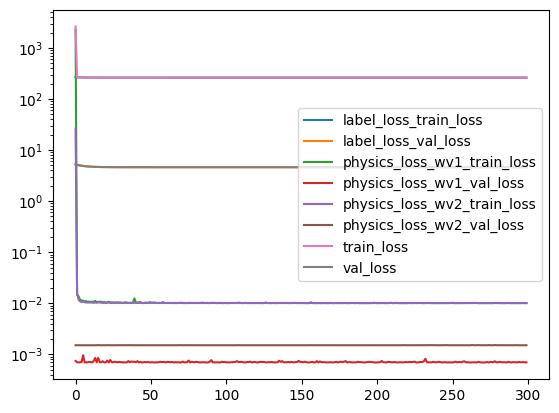

In [51]:
criterion.loss_tracker.plot_losses()
# plt.yscale('log')
print("Unweighted Training Label loss(MSE)", criterion1.loss_tracker.epoch_losses['label_loss_train_loss'][-1])
print("Unweighted Validation Label loss(MSE)", criterion1.loss_tracker.epoch_losses['label_loss_val_loss'][-1])
fig_loss = plt.gcf()
plt.yscale('log')

In [52]:
# Increase batch_size for faster visuals generation - (does not affect training!)
prev_batch_size = dataloader_gen.batch_size
trainer.set_batch_size(4096)
# Does MAE by default. Provide a value to error_func to change it
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)
trainer.set_batch_size(prev_batch_size)

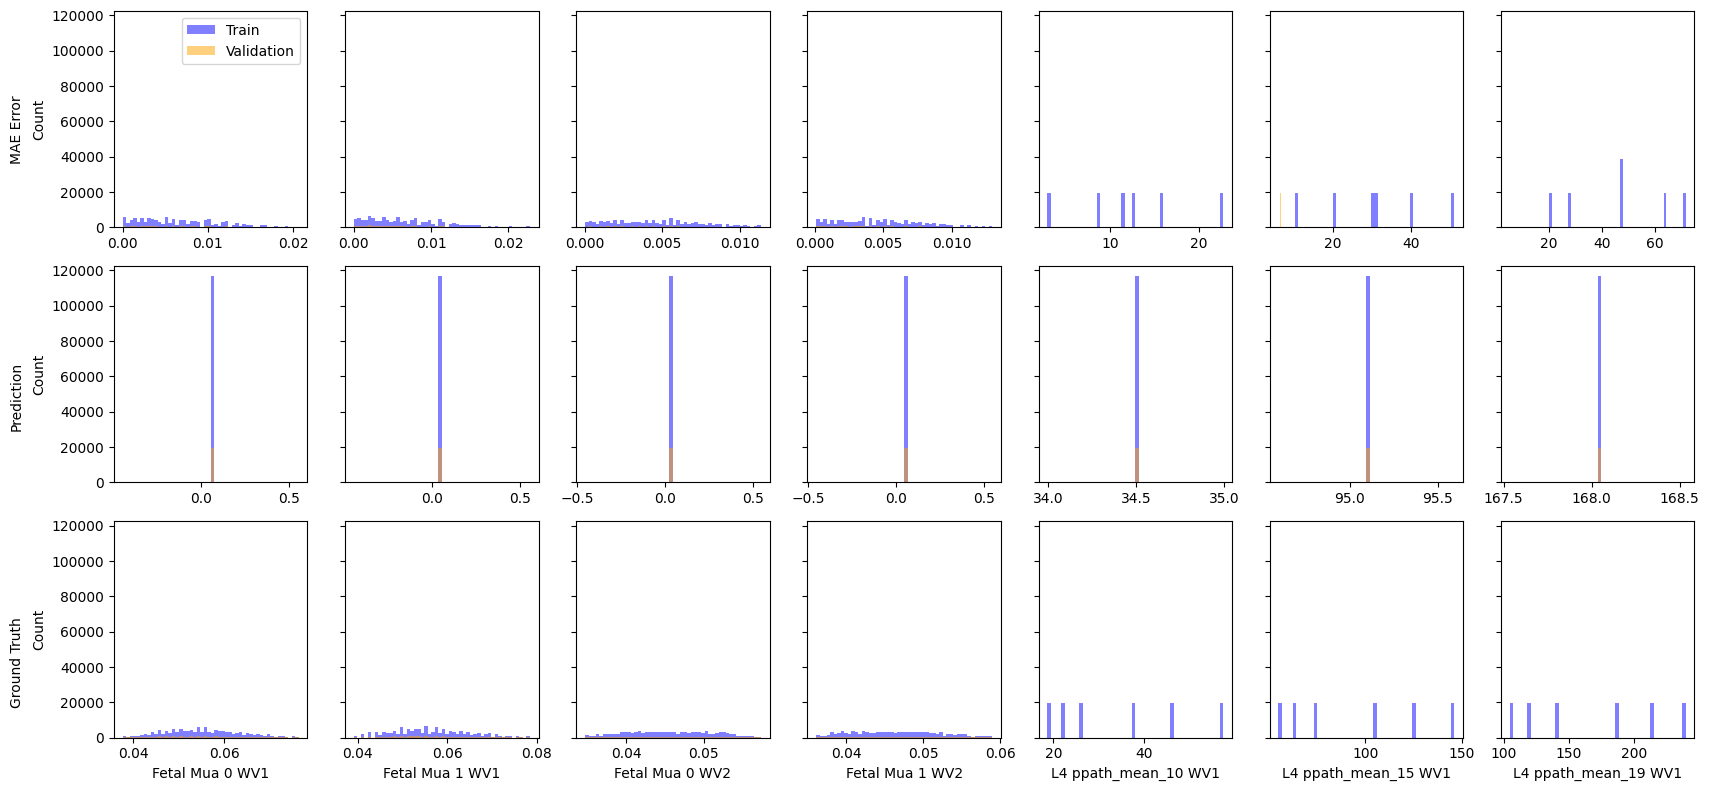

In [53]:
PLOT_FIRST_N = 7
y_columns_to_plot = y_columns[:PLOT_FIRST_N]
fig_dist, axes = plt.subplots(3, len(y_columns_to_plot), squeeze=True, figsize=(17, 8), sharey=True)
BIN_COUNT = 50

train_data_truth = y_scaler.inverse_transform(trainer.train_loader.dataset[:][1].cpu())
val_data_truth = y_scaler.inverse_transform(trainer.validation_loader.dataset[:][1].cpu())

for i in range(len(y_columns_to_plot)):
    # Plot Errors
    ax = axes[0, i]
    plt.sca(ax)
    column_name = train_error.columns[i]
    plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Predictions
    ax = axes[1, i]
    plt.sca(ax)
    column_name = train_pred.columns[i]
    plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Ground Truth
    ax = axes[2, i]
    plt.sca(ax)
    plt.hist(train_data_truth[:, i], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_data_truth[:, i], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    # X Label for the bottommost row
    plt.xlabel(y_columns[i])
    
# Add text to the left of each row of plots
for i, label in enumerate(['MAE Error', 'Prediction', 'Ground Truth']):
    fig_dist.text(0, (2.5-i)/3, label, ha='center', va='center', rotation='vertical')

# Y Labels
for i in range(axes.shape[0]):
    axes[i, 0].set_ylabel('Count')

# Add labels to top-left subplot
axes[0, 0].legend()


plt.tight_layout()
plt.show()

In [54]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       2,460
│    └─BatchNorm1d: 2-2                  120
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       3,050
│    └─BatchNorm1d: 2-6                  100
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       2,244
│    └─BatchNorm1d: 2-10                 88
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      1,980
│    └─Flatten: 2-14                     --
Total params: 10,042
Trainable params: 10,042
Non-trainable params: 0

In [55]:
# model_name = 'msat_percep_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler') 

In [56]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')

In [57]:
# from mdreport import MarkdownReport
# # Generate report

# report = MarkdownReport(Path('results'), 'report8', 'Applying Physics Loss')
# report.add_text_report("Objective", "Using Hold One Out validation Split - Predicting Delta instead of True Mu A")
# report.add_text_report("Comment", "More or less similar results tbh. not much of an improvement")
# report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
# report.add_code_report("Unnormalized Errors", str(train_error.iloc[:, :4].describe()) + '\n\n' + str(val_error.iloc[:, :4].describe())) 
# report.add_text_report("Loss", f"""Label Loss(training): {criterion1.loss_tracker.epoch_losses['label_loss_train_loss'][-1]},
#                        Label loss(validation): {criterion1.loss_tracker.epoch_losses['label_loss_val_loss'][-1]}""")
# report.add_code_report("Model Trainer Params", str(trainer))
# report.add_image_report("Loss Curves", fig_loss)
# report.add_image_report("Prediction & Error Distribution", fig_dist)
# report.save_report()